In [398]:
import numpy as np
import pandas as pd
import stockstats as st
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import timeit

In [399]:
data = st.StockDataFrame.retype(pd.read_csv('/home/anupam/stockPrediction/data/^BSESN (5).csv'))
daysToForecast = 10

In [400]:
data.index = pd.to_datetime(data.index)
data.interpolate(method='time',inplace=True)
#data.dropna(inplace=True)

In [401]:
SMA5 = data['adj close'].rolling(window=5).mean()
SMA10 = data['adj close'].rolling(window=10).mean()
SMA20 = data['adj close'].rolling(window=20).mean()
data = pd.concat([data,SMA5,SMA10,SMA20],axis=1,sort=False)
data.columns.values[6] = 'sma5'
data.columns.values[7] = 'sma10'
data.columns.values[8] = 'sma20'

In [402]:
prev = 0
i = 1
def calc(diff,volume):
    "part of on balance volume"
    global i
    global prev
    if i == 1:
        i = 0
        prev = volume
        return volume
    elif diff > 0:
        value = prev = prev + volume
        return value
    elif diff < 0:
        value = prev = prev - volume
        return value
    elif diff == 0:
        value = prev
        return value

def OBV(data):
    "function to calculate on balance volume"
    data['prior close'] = data['adj close'].shift(1)
    data['diff'] = data['adj close'] - data['prior close']
    temp = [calc(x,y) for x,y in zip(data['diff'].values[1:],data['volume'].values[1:])]
    temp = temp + [0]
    temp = np.array(temp)
    data['obv'] = temp
    data['obv'] = data['obv'].shift(1)
    data.drop(['prior close','diff'],axis=1,inplace=True)
    return data

data = OBV(data)

In [403]:
data['macd']  #to calculate moving avrage convergence divergence
data['rsi_10']#to calculate relative strength index for 10 dsys
data['rsi_20']#to calculate relative strength index for 20 days
data['cci_20']#to calculate commodity channel index for 20 days
data['atr']   #to calculate average true range for 14 days
data['wr_14'] #to calculate williams%R for 14 days
data['kdjk']  #a stochastic oscillator
data['kdjd']  #a stochastic oscillator(here a is used so that cell doesn't display the series)
a = data['trix'] # to calculate triple exponentially smoothed moving average

/home/anupam/anaconda3/lib/python3.6/site-packages/stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())


In [404]:
featureList = ['open', 'high', 'low', 'adj close','volume','sma5','sma10','sma20','macd','rsi_10', 'rsi_20','cci_20','atr','wr_14','kdjk','kdjd','obv','trix']
data1 = data[featureList]

In [405]:
data1.dropna(inplace=True)

In [406]:
data1.shape

(5278, 18)

In [407]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
data1Scaled = pd.DataFrame(scaler.fit_transform(data1),columns=featureList)

In [408]:
data1Scaled['Label'] = np.array(data1['adj close'].shift(-(daysToForecast)).values)

In [409]:
data2Scaled = data1Scaled.dropna(inplace=False)

In [410]:
l = data2Scaled.corr()['Label']
pd.DataFrame(data={'Technical Indicator':l.index.values[:-1], 'Correlation coefficients':l.values[:-1]},index=(range(1,19)))

,Technical Indicator,Correlation coefficients
1,open,0.997824
2,high,0.997905
3,low,0.997916
4,adj close,0.997973
5,volume,0.181103
6,sma5,0.997740
7,sma10,0.997401
8,sma20,0.996707
9,macd,0.182463
10,rsi_10,0.087348


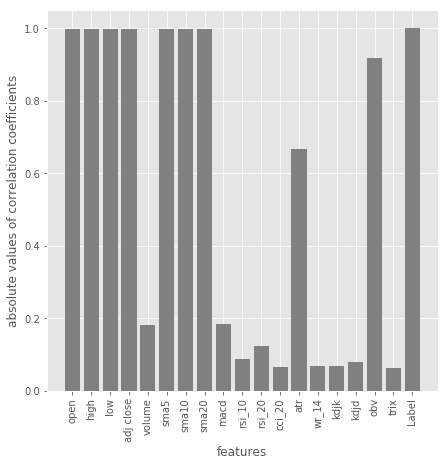

In [411]:
plt.figure(figsize=(7,7))
plt.bar(data2Scaled.columns.values,abs(data2Scaled.corr()['Label'].values),color='gray')
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('absolute values of correlation coefficients')
plt.show()

In [412]:
list = [column for column in l.index.values if 0.5<abs(l[column])<1]

In [413]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data2Scaled[list])
pcaData = pca.transform(data2Scaled[list])

In [414]:
components = ['PC' + str(x) for x in range(1,len(pca.explained_variance_)+1)]
varianceTable = pd.DataFrame({'Variance':pca.explained_variance_,'Variance %': pca.explained_variance_ratio_*100},index=components)

In [415]:
varianceTable

,Variance,Variance %
PC1,8.308972,92.889497
PC2,0.532379,5.951691
PC3,0.101138,1.130663
PC4,0.001995,0.022302
PC5,0.000273,0.003050
PC6,0.000136,0.001526
PC7,0.000052,0.000577
PC8,0.000050,0.000556
PC9,0.000012,0.000138


In [416]:
selectedComponents = [x for x,y in zip(range(len(pca.explained_variance_)),pca.explained_variance_) if y>=0.1]

In [417]:
componentTable = pd.DataFrame(index=list)
for x in selectedComponents:
    componentTable['PC' + str(x+1)] = pd.Series(pca.components_[x],index=list)

In [418]:
componentTable

,PC1,PC2,PC3
open,0.343859,-0.126900,0.093234
high,0.343996,-0.121508,0.092480
low,0.343671,-0.134465,0.089196
adj close,0.343839,-0.127684,0.089683
sma5,0.343888,-0.125485,0.093966
sma10,0.343919,-0.120871,0.100586
sma20,0.343958,-0.110943,0.113547
atr,0.254445,0.924650,0.282472
obv,0.327878,0.192627,-0.924730


In [419]:
pcaData = pd.DataFrame(data=pcaData) 

In [420]:
X = np.array(pcaData[selectedComponents])
y = np.array(data2Scaled['Label'])

In [421]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

In [422]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

In [423]:
# X_validation = X_train[-int((X_train.shape[0]*0.2)):]
# y_validation = y_train[-int((y_train.shape[0]*0.2)):]
# X_train = X_train[:-int((X_train.shape[0]*0.2))]
# y_train = y_train[:-int((y_train.shape[0]*0.2))]

In [424]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.35,shuffle=False)

In [425]:
svr_rbf = svm.SVR(C=10000,gamma=0.001,epsilon=0.1)
startTime = timeit.default_timer()
svr_rbf.fit(X_train,y_train)
endTime = timeit.default_timer()
print(svr_rbf)
print("R-squared for training set = {}".format(svr_rbf.score(X_train,y_train)))
print("R-squared for validation set = {}".format(svr_rbf.score(X_validation,y_validation)))
print("R-squared for test set = {}".format(svr_rbf.score(X_test,y_test)))
print("MSE:{}".format(mean_squared_error(y_test,svr_rbf.predict(X_test))))
print("MAE:{}".format(mean_absolute_error(y_test,svr_rbf.predict(X_test))))
print("MAPE:{} %".format((abs((y_test-svr_rbf.predict(X_test)))/y_test).mean()*100))
print("Time:{}".format(endTime-startTime))

SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R-squared for training set = 0.9899261914322247
R-squared for validation set = 0.9296268734794811
R-squared for test set = 0.8653870044456685
MSE:1464139.5921622103
MAE:1012.1206673055298
MAPE:3.444439947509708 %
Time:0.4956455850006023


In [426]:
svr_poly = svm.SVR(C=100000,gamma=0.1,epsilon=0.0001,kernel='poly',degree=3)
startTime =timeit.default_timer()
svr_poly.fit(X_train,y_train)
endTime = timeit.default_timer()
print(svr_poly)
print("R-squared for training set = {}".format(svr_poly.score(X_train,y_train)))
print("R-squared for validation set = {}".format(svr_poly.score(X_validation,y_validation)))
print("R-squared for test set = {}".format(svr_poly.score(X_test,y_test)))
print("MSE:{}".format(mean_squared_error(y_test,svr_poly.predict(X_test))))
print("MAE:{}".format(mean_absolute_error(y_test,svr_poly.predict(X_test))))
print("MAPE:{} %".format((abs((y_test-svr_poly.predict(X_test)))/y_test).mean()*100))
print("Time:{}".format(endTime-startTime))

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma=0.1,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R-squared for training set = 0.9278767996654788
R-squared for validation set = -0.4852916774074194
R-squared for test set = -177.54229261359563
MSE:1941943557.6371765
MAE:27855.14079919139
MAPE:87.18857559610889 %
Time:0.9055441360014811


In [427]:
svr_sigmoid = svm.SVR(C=10000,gamma=0.001,epsilon=0.1,kernel='sigmoid')
startTime = timeit.default_timer()
svr_sigmoid.fit(X_train,y_train)
endTime = timeit.default_timer()
print(svr_sigmoid)
print("R-squared for training set = {}".format(svr_sigmoid.score(X_train,y_train)))
print("R-squared for validation set = {}".format(svr_sigmoid.score(X_validation,y_validation)))
print("R-squared for test set = {}".format(svr_sigmoid.score(X_test,y_test)))
print("MSE:{}".format(mean_squared_error(y_test,svr_sigmoid.predict(X_test))))
print("MAE:{}".format(mean_absolute_error(y_test,svr_sigmoid.predict(X_test))))
print("MAPE:{} %".format((abs((y_test-svr_sigmoid.predict(X_test)))/y_test).mean()*100))
print("Time:{}".format(endTime-startTime))

SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R-squared for training set = 0.988936220363477
R-squared for validation set = 0.9200592629145022
R-squared for test set = 0.7682763155318422
MSE:2520379.3992876224
MAE:1403.5503780833076
MAPE:4.817159216680906 %
Time:0.47858079000070575


In [428]:
svr_linear = svm.SVR(C=10,epsilon=0.0001,kernel='linear')
startTime = timeit.default_timer()
svr_linear.fit(X_train,y_train)
endTime = timeit.default_timer()
print(svr_linear)
print("R-squared for training set = {}".format(svr_linear.score(X_train,y_train)))
print("R-squared for validation set = {}".format(svr_linear.score(X_validation,y_validation)))
print("R-squared for test set = {}".format(svr_linear.score(X_test,y_test)))
print("MSE:{}".format(mean_squared_error(y_test,svr_linear.predict(X_test))))
print("MAE:{}".format(mean_absolute_error(y_test,svr_linear.predict(X_test))))
print("MAPE:{} %".format((abs((y_test-svr_linear.predict(X_test)))/y_test).mean()*100))
print("Time:{}".format(endTime-startTime))

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R-squared for training set = 0.9889353902019885
R-squared for validation set = 0.9200463723056566
R-squared for test set = 0.7682876375963666
MSE:2520256.253057446
MAE:1403.5396902647117
MAPE:4.817193670923745 %
Time:0.36486381699978665


In [429]:
predict = svr_rbf.predict(np.concatenate((X_train,X_validation,X_test),axis=0))

In [430]:
df = pd.DataFrame(data=data1['adj close'])
df['Forecasted close'] =np.concatenate((np.array([np.nan for x in range(daysToForecast)]), predict),axis=0)
df.dropna(inplace=True)

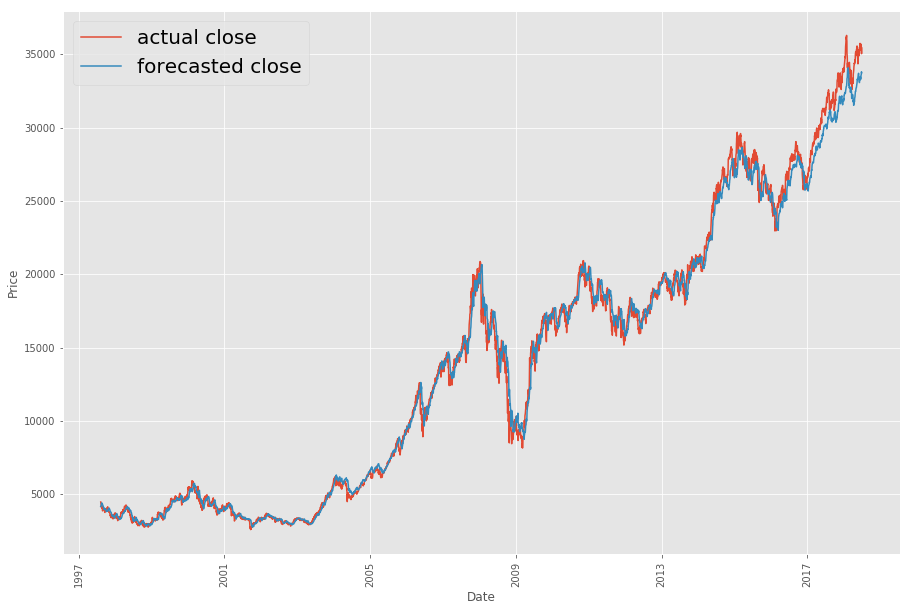

In [431]:
plt.figure(figsize=(15,10))
plt.plot(df['adj close'],label='actual close')
plt.plot(df['Forecasted close'],label='forecasted close')
# plt.plot(range(y_test.shape[0]),y_test,label='actual close')
# plt.plot(range(y_test.shape[0]),svr_rbf.predict(X_test),label='forecasted close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.legend(fontsize=20)
plt.show()

In [432]:
X_test.shape

(1054, 3)

In [433]:
X_validation.shape

(1475, 3)

In [434]:
X_train.shape

(2739, 3)

In [435]:
timeit.default_timer()

8204.179180933